In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

347 total WT RuBisCOs
200 RuBisCOs with all core kinetic data measured


In [4]:
# kon_O vs kon_C
kon_Os = np.log(raw_kin_df.kon_O)
kon_Cs = np.log(raw_kin_df.kon_C)

print('Whole dataset correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

fIs = raw_kin_df[raw_kin_df.isoform == '1']
kon_Os = np.log(fIs.kon_O)
kon_Cs = np.log(fIs.kon_C)

print('FI dataset correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

kon_Os = np.log(savir_df.kon_O)
kon_Cs = np.log(savir_df.kon_C)

print('Savir correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

Whole dataset correlation
Log-scale linear regression R = 0.63, P = 6.1e-23
Spearman rank correlation R = 0.85, P = 5.7e-54
FI dataset correlation
Log-scale linear regression R = 0.93, P = 7e-82
Spearman rank correlation R = 0.93, P = 7.4e-81
Savir correlation
Log-scale linear regression R = 0.58, P = 0.019
Spearman rank correlation R = 0.48, P = 0.059


In [5]:
idxs = np.random.choice(100, 10)
idxs

array([72, 40, 66, 96, 17, 87, 84, 11, 62, 92])

In [6]:
# Bootstrapped regression over the FI rubiscos
# Note: we are bootstrapping here, but konC and konO are not expected to follow a normal distribution.
# Why? because they are calculated as the ratio of experimentally measured values, which are assumed to 
# be normally distributed. So the strategy here is to sample the measurements from a normal distribution
# and then calculate konC and konO from there.

# konC = vC/KC (both measured)
# konO = vO/KO (vO not measured)
# S = vC/KC / (vO/KO)
# Therefore,
# vO = vC/KC / (S/KO) and
# konO = vC/KC / (S/KO) / (KO) = vC/(S KC)

all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
fraction = 0.9
tot = all_FIs.kon_C.size
subset_size = int(fraction * tot)

runs = 10000
exponents = []
prefactors = []
prefactors_1 = []
for _ in range(runs):
    idxs = np.random.choice(tot, subset_size)
    subset = all_FIs.iloc[idxs]
    
    # Make konC sample
    vC_vals = np.random.normal(subset.vC, subset.vC_SD)
    KC_vals = np.random.normal(subset.KC, subset.KC_SD)
    konC_vals = vC_vals / KC_vals

    # Independent konO sample
    S_vals = np.random.normal(subset.S, subset.S_SD)
    vC_vals = np.random.normal(subset.vC, subset.vC_SD)
    KC_vals = np.random.normal(subset.KC, subset.KC_SD)
    konO_vals = vC_vals / KC_vals / S_vals
    
    log_konC = np.log(konC_vals)
    log_konO = np.log(konO_vals)
    
    # Fit a power law.
    exp, pre, _ = power_laws.fit_power_law_odr(log_konO, log_konC)
    exponents.append(exp)
    prefactors.append(pre)
    
    # Fit a power law with exp = 1.0
    exp, pre, _ = power_laws.fit_power_law_odr(log_konO, log_konC, unit_exp=True)
    prefactors_1.append(pre)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log


[ 82.25196127 406.00203897]
[0.97993349 1.23993928]


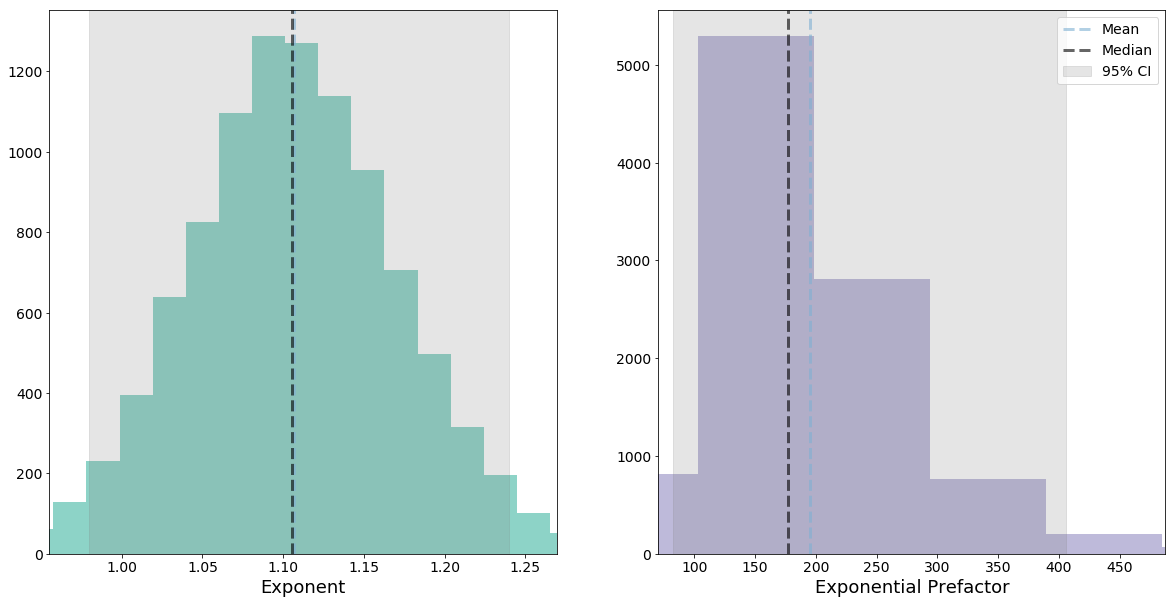

In [7]:
power_laws.plot_bootstrapped_range(exponents, prefactors)

In [8]:
# Range on prefactor assuming exponent = 1.0
conf_range = [2.5, 97.5]
pre1_interval = np.percentile(prefactors_1, conf_range)
pre1_interval
print(pre1_interval)

R = 8.314e-3 # kJ/mol/K
T = 298.15   # K
pre1_interval * R * T

[88.43274804 95.77557292]


array([219.20878491, 237.41031947])

In [9]:
# Regress on savir data to get previous fit. 
# NOTE: 1. Savir drops the FII Rubiscos for this fit, I think. Unclear from text if he dropped both or one.
# NOTE: 2. Can't reproduce his exponent of 0.5. I get 0.77. 
savir_FI = savir_df[savir_df.isoform == '1']

konOs = np.log(savir_FI.kon_O)
konCs = np.log(savir_FI.kon_C)
exp_savir, pre_savir, r = power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False)
print(exp_savir, pre_savir, r)

1.2939595234935644 450.9393762832956 0.84012693093361


1.0787594008395975 151.23451032219234 0.9299546351297863
1.2939595234935644 450.9393762832956 0.9299546351297863


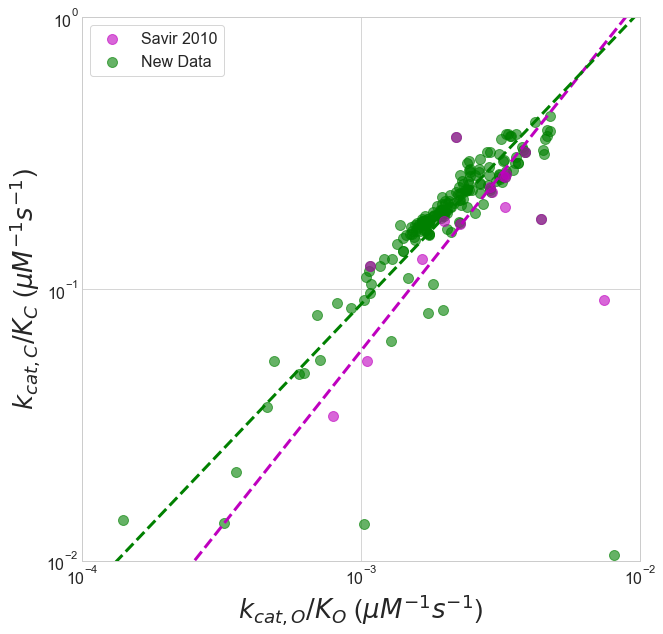

In [10]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)


# Regress against FI data, which is closest to the front. 
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
konOs = np.log(all_FIs.kon_O)
konCs = np.log(all_FIs.kon_C)
exp_allFI, pre_allFI, r = power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False)
print(exp_allFI, pre_allFI, r)

plt.xscale('log')
plt.yscale('log')

plt.scatter(savir_df.kon_O, savir_df.kon_C, c='m', s=100, label='Savir 2010', zorder=10, alpha=0.6)
plt.scatter(nonsavir_df.kon_O, nonsavir_df.kon_C, c='g', s=100, label='New Data', alpha=0.6)

xs = np.arange(1e-4, 2e-2, 0.01)
plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='m', lw=3, ls='--')
print(exp_savir, pre_savir, r)
plt.plot(xs, np.power(xs, exp_allFI)*pre_allFI, c='g', lw=3, ls='--')

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig5/fig5_konC_konO.png', dpi=600)
plt.savefig('fig5/fig5_konC_konO.svg')

plt.show()

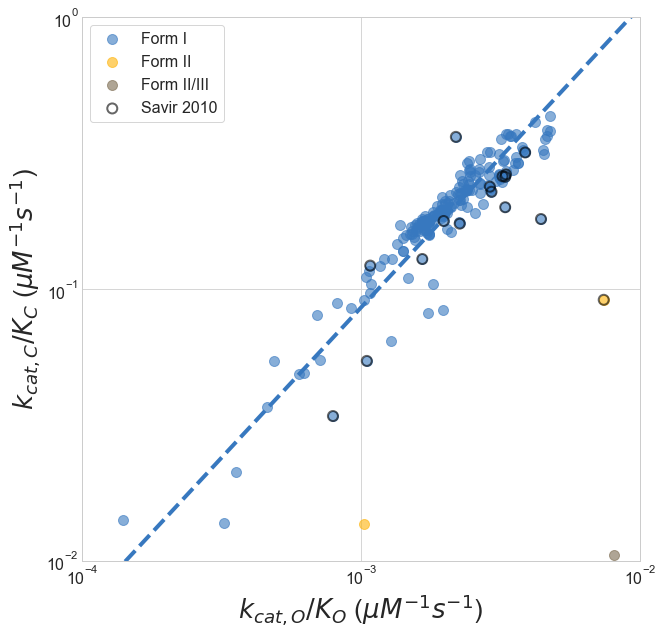

In [11]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.kon_O, gdf.kon_C,  c=c, s=100, label=label, alpha=0.6)

# Plot our regression and CI
xs = np.arange(1e-4, 2e-2, 0.01)
c = matplotlib.colors.rgb2hex(named_colors[0])
power_laws.plot_bootstrapped_ci(xs, exponents, prefactors, figure=figure, color=c,
                                lw=4, plot_range=False)

# Savir power law, inferred
#plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='grey', lw=2, ls='--')

# Show savir data with an outline
plt.scatter(savir_df.kon_O, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=2, s=100, label='Savir 2010', alpha=0.6, zorder=10)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig5/fig5_konC_konO_FI.png', dpi=600)
plt.savefig('fig5/fig5_konC_konO_FI.svg')

plt.show()

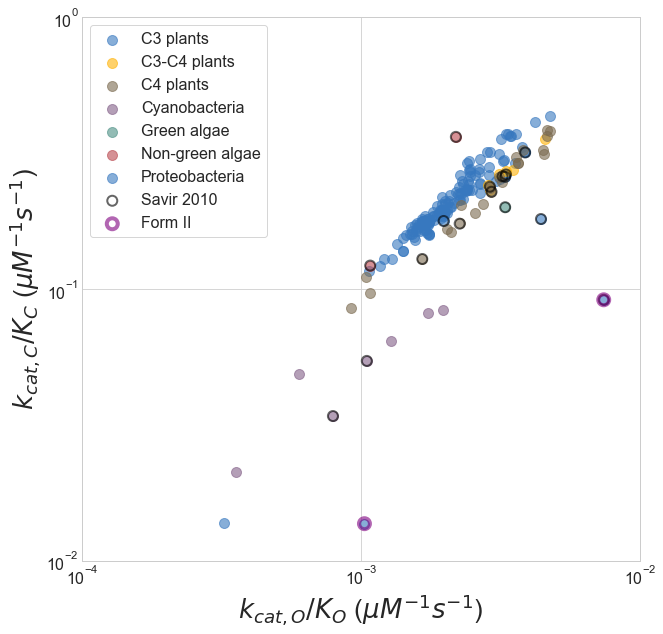

In [15]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC color by isoform
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Non-green algae': 'Non-green algae',
                 'Alphaproteobacteria': 'Proteobacteria',
                 'Betaproteobacteria': 'Proteobacteria',
                 'Gammaproteobacteria': 'Proteobacteria',
                }
grouped_taxa = raw_kin_df.set_index('taxonomy').groupby(group_mapping)
groups2use = set(['C3 plants', 'Cyanobacteria', 'C4 plants',
                  'Green algae', 'Non-green algae', 'C3-C4 plants', 'Proteobacteria']) 

for i, (group, gdf) in enumerate(grouped_taxa):
    if group not in groups2use:
        continue
        
    label = group
    c = matplotlib.colors.rgb2hex(named_colors[i % len(named_colors)])
    plt.scatter(gdf.kon_O, gdf.kon_C, c=c, s=100, label=label, alpha=0.6)

# Show savir data with an outline
plt.scatter(savir_df.kon_O, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=2, s=100, label='Savir 2010', alpha=0.6, zorder=10)

# Show FII data with an outline
FII_only = raw_kin_df[raw_kin_df.isoform == '2']
plt.scatter(FII_only.kon_O, FII_only.kon_C, c='None', edgecolors='purple',
            linewidths=4, s=120, label='Form II', alpha=0.6, zorder=10)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.show()

In [13]:
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
konOs = np.log(all_FIs.kon_O)
konCs = np.log(all_FIs.kon_C)
print('Free exp')
print(power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False))

print('exponent=1.0')
print(power_laws.fit_power_law_odr(konOs, konCs, unit_exp=True))

Free exp
(1.0787594008395975, 151.23451032219234, 0.9299546351297863)
exponent=1.0
(1, 92.73492360272775, 0.9299546351297862)


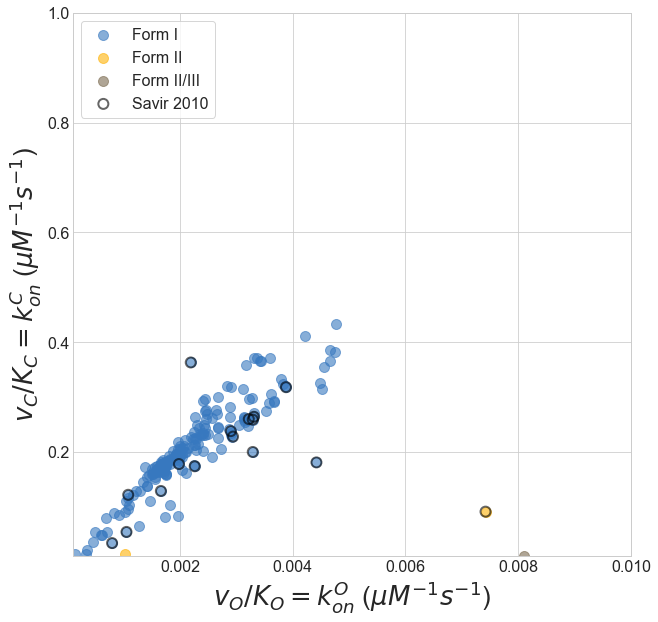

In [14]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO.
# Plotting in linear scale.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.kon_O, gdf.kon_C,  c=c, s=100, label=label, alpha=0.6)

# Plot our regression and CI
#xs = np.arange(1e-4, 2e-2, 0.01)
#c = matplotlib.colors.rgb2hex(named_colors[0])
#power_laws.plot_bootstrapped_ci(xs, exponents, prefactors, figure=figure, color=c,
#                                lw=4, plot_range=False)

# Savir power law, inferred
#plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='grey', lw=2, ls='--')

# Show savir data with an outline
plt.scatter(savir_df.kon_O, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=2, s=100, label='Savir 2010', alpha=0.6, zorder=10)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$v_O / K_O = k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$v_C / K_C = k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig5/fig5_konC_konO_FI_linear.png', dpi=600)
plt.savefig('fig5/fig5_konC_konO_FI_linear.svg')

plt.show()